In [3]:
import warnings
warnings.filterwarnings('ignore')
import flowermd
import hoomd
from flowermd.library import PolyEthylene, OPLS_AA
from flowermd import Pack
from flowermd.modules.welding import SlabSimulation, Interface, WeldSimulation
from cmeutils.visualize import FresnelGSD
import gsd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import unyt as u

/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/mdtraj/formats/__init__.py:13: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from mdtraj.formats.trr import TRRTrajectoryFile


In [1]:
molecule = PolyEthylene(num_mols=30, lengths=12)
cpu = hoomd.device.CPU() # So I don't get a CUDA error

# Create a slab
system = Pack(
    molecules=molecule,
    density=1.1 * u.g/u.cm**3,
)
system.apply_forcefield(r_cut=2.5, force_field=OPLS_AA(), auto_scale=True,remove_charges=True, remove_hydrogens=True)
sim = SlabSimulation.from_system(
    system=system,
    interface_axis=(1,0,0),
    gsd_file_name="slab_x_interface.gsd", device = cpu
)
sim.forces
for wall in sim.forces[-1].walls:
    print(wall)
print()
print("Simulation volume:", sim.box_lengths_reduced)
target_box = flowermd.utils.get_target_box_mass_density(density=1.2*u.g/u.cm**3, mass=sim.mass.to("g"))

sim.run_update_volume(final_box_lengths=target_box, n_steps=5e4, kT=5.0, period=100, tau_kt=0.001)
sim.run_NVT(kT=5.0, n_steps=4e4, tau_kt=0.001)
sim.remove_walls(wall_axis=(1,0,0))
sim.pickle_forcefield()
sim.flush_writers()
sim_viewer = FresnelGSD(gsd_file="slab_x_interface.gsd", view_axis=(0, 1, 0), frame=-1)
sim_viewer.view()

# Create interface from the slab
interface = Interface(gsd_files=["slab_x_interface.gsd"], interface_axis=(1, 0, 0), gap=0.05)
print(type(interface.hoomd_snapshot))
print("Slab number of particles:", system.n_particles)
print("Interface number of particles:", interface.hoomd_snapshot.particles.N)
print()
print("Slab box lengths:", sim.box_lengths_reduced)
print("Interface box lengths:", interface.hoomd_snapshot.configuration.box[:3])

/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/mdtraj/formats/__init__.py:13: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from mdtraj.formats.trr import TRRTrajectoryFile


No charged group detected, skipping electrostatics.
Initializing simulation state from a gsd.hoomd.Frame.
Plane(origin=_HOOMDTuple(17.74683380126953, 0.0, 0.0), normal=_HOOMDTuple(-1.0, 0.0, 0.0), 
Plane(origin=_HOOMDTuple(-17.74683380126953, -0.0, -0.0), normal=_HOOMDTuple(1.0, 0.0, 0.0), 

Simulation volume: [35.4936676 35.4936676 35.4936676]
Step 5500 of 50000; TPS: 4048.57; ETA: 0.2 minutes
Step 11000 of 50000; TPS: 4324.09; ETA: 0.2 minutes
Step 16500 of 50000; TPS: 4428.53; ETA: 0.1 minutes
Step 22000 of 50000; TPS: 4423.68; ETA: 0.1 minutes
Step 27500 of 50000; TPS: 4406.98; ETA: 0.1 minutes
Step 33000 of 50000; TPS: 4319.91; ETA: 0.1 minutes
Step 38500 of 50000; TPS: 4187.67; ETA: 0.0 minutes
Step 44000 of 50000; TPS: 3892.85; ETA: 0.0 minutes
Step 49500 of 50000; TPS: 3296.74; ETA: 0.0 minutes
Step 4999 of 40000; TPS: 973.62; ETA: 0.6 minutes
Step 10499 of 40000; TPS: 974.75; ETA: 0.5 minutes
Step 15999 of 40000; TPS: 976.63; ETA: 0.4 minutes
Step 21499 of 40000; TPS: 980.03; 

<class 'gsd.hoomd.Frame'>
Slab number of particles: 720
Interface number of particles: 1440

Slab box lengths: [6.89579988 6.89579988 6.89579988]
Interface box lengths: [12.8416  6.8958  6.8958]
Initializing simulation state from a gsd.hoomd.Frame.
Plane(origin=_HOOMDTuple(6.42080020904541, 0.0, 0.0), normal=_HOOMDTuple(-1.0, 0.0, 0.0), 
Plane(origin=_HOOMDTuple(-6.42080020904541, -0.0, -0.0), normal=_HOOMDTuple(1.0, 0.0, 0.0), 

Simulation volume: [12.84160042  6.89580011  6.89580011]
Step 5250 of 70000; TPS: 215.84; ETA: 5.0 minutes
Step 10500 of 70000; TPS: 218.92; ETA: 4.5 minutes
Step 15750 of 70000; TPS: 252.91; ETA: 3.6 minutes
Step 21000 of 70000; TPS: 281.26; ETA: 2.9 minutes
Step 26250 of 70000; TPS: 301.85; ETA: 2.4 minutes
Step 31500 of 70000; TPS: 316.84; ETA: 2.0 minutes
Step 36750 of 70000; TPS: 329.25; ETA: 1.7 minutes
Step 42000 of 70000; TPS: 337.93; ETA: 1.4 minutes
Step 47250 of 70000; TPS: 344.9; ETA: 1.1 minutes
Step 52500 of 70000; TPS: 351.59; ETA: 0.8 minutes
S

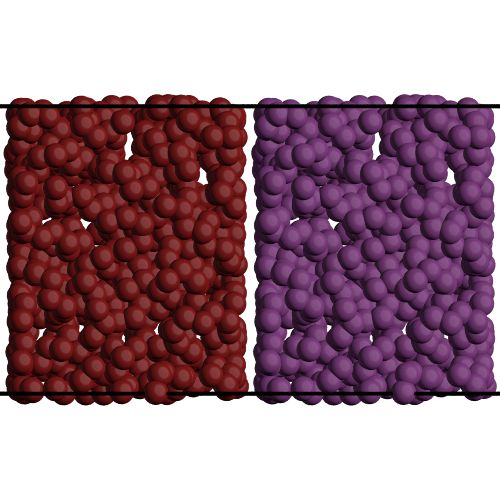

In [9]:
# Running a welding simulation
# Open and load the forcefield picke file
with open("forcefield.pickle", "rb") as f:
    hoomd_forces = pickle.load(f)


weld_sim = WeldSimulation(
    initial_state=interface.hoomd_snapshot,
    forcefield=hoomd_forces,
    interface_axis=(1, 0, 0),
    gsd_file_name="weld.gsd",
    log_file_name="weld_log.txt",
    log_write_freq=500,
    dt=0.0003, device = cpu
)
weld_sim.forces
for wall in weld_sim.forces[-1].walls:
    print(wall)
print()
print("Simulation volume:", weld_sim.box_lengths_reduced)
weld_sim.run_NVT(kT=10.0, n_steps=7e4, tau_kt=0.001)
cooling_ramp = weld_sim.temperature_ramp(n_steps=2e4, kT_start=10.0, kT_final=2.0)
weld_sim.run_NVT(kT=cooling_ramp, n_steps=2e4, tau_kt=0.001)
weld_sim.save_restart_gsd("weld_restart.gsd")
weld_sim.flush_writers()
sim_viewer = FresnelGSD(gsd_file="weld.gsd", view_axis=(0, 1, 0), frame=0, height=12)
weld_colors = np.zeros_like(sim_viewer.positions)
weld_colors[:weld_colors.shape[0]//2 + 1] = np.array([0.5, 0.25, 0.5])
weld_colors[weld_colors.shape[0]//2 + 1:] = np.array([0.5, 0.1, 0.1])
sim_viewer.colors = weld_colors
sim_viewer.view(width=500, height=500)

In [11]:
# Running a tensile test simulation
from flowermd.library.simulations.tensile import Tensile
# Open and load the forcefield picke file
with open("forcefield.pickle", "rb") as f:
    hoomd_forces = pickle.load(f)
    
tensile_sim = Tensile(
    initial_state="weld_restart.gsd",
    forcefield=hoomd_forces,
    tensile_axis=(1,0,0),
    gsd_file_name="pe-tensile.gsd",
    gsd_write_freq=1000,
    log_file_name="pe-tensile_log.txt",
    log_write_freq=500,
    fix_ratio=0.30,
    device = cpu
)
tensile_sim.run_tensile(n_steps=1e5, strain=0.30, period=500, kT=2.0, tau_kt=0.001)
tensile_sim.flush_writers()

Initializing simulation state from a GSD file.
Step 0 of 100001; TPS: 0.0; ETA: nan hours, nan minutes
Step 750 of 100001; TPS: 396.61; ETA: 4.2 minutes
Step 1500 of 100001; TPS: 439.69; ETA: 3.7 minutes
Step 2250 of 100001; TPS: 452.58; ETA: 3.6 minutes
Step 3000 of 100001; TPS: 457.6; ETA: 3.5 minutes
Step 3750 of 100001; TPS: 461.83; ETA: 3.5 minutes
Step 4500 of 100001; TPS: 464.61; ETA: 3.4 minutes
Step 5250 of 100001; TPS: 463.61; ETA: 3.4 minutes
Step 6000 of 100001; TPS: 459.6; ETA: 3.4 minutes
Step 6750 of 100001; TPS: 460.62; ETA: 3.4 minutes
Step 7500 of 100001; TPS: 462.69; ETA: 3.3 minutes
Step 8250 of 100001; TPS: 462.2; ETA: 3.3 minutes
Step 9000 of 100001; TPS: 462.82; ETA: 3.3 minutes
Step 9750 of 100001; TPS: 463.17; ETA: 3.2 minutes
Step 10500 of 100001; TPS: 463.63; ETA: 3.2 minutes
Step 11250 of 100001; TPS: 463.12; ETA: 3.2 minutes
Step 12000 of 100001; TPS: 464.01; ETA: 3.2 minutes
Step 12750 of 100001; TPS: 465.3; ETA: 3.1 minutes
Step 13500 of 100001; TPS: 464.

In [12]:
import freud
traj = gsd.hoomd.open('pe-tensile.gsd')
def nop(frame):
    positions = frame.particles.position
    molecule_ids = frame.bonds.group
    vectors = []
    for group in frame.bonds.group:
        vectors.append(positions[group[1]] - positions[group[0]])
    vectors = np.array(vectors)
    return vectors

In [13]:
nematic = freud.order.Nematic(np.array([1,0,0]))
import time
start = time.process_time()
orders = []
frames = []
count = 0
for frame in traj:
    count += 1
    frames.append(count)
    nematic.compute(nop(frame))
    orders.append(nematic.order)
    print("Nematic Order Parameter:", nematic.order)
print("Time taken:", time.process_time() - start, "s")

Nematic Order Parameter: 0.06298863142728806
Nematic Order Parameter: 0.06392496079206467
Nematic Order Parameter: 0.06467407196760178
Nematic Order Parameter: 0.06557103991508484
Nematic Order Parameter: 0.06707707792520523
Nematic Order Parameter: 0.05921086296439171
Nematic Order Parameter: 0.05955502390861511
Nematic Order Parameter: 0.05687010660767555
Nematic Order Parameter: 0.055743761360645294
Nematic Order Parameter: 0.05398944765329361
Nematic Order Parameter: 0.05782085284590721
Nematic Order Parameter: 0.05182310566306114
Nematic Order Parameter: 0.05232759192585945
Nematic Order Parameter: 0.05290061980485916
Nematic Order Parameter: 0.05075256898999214
Nematic Order Parameter: 0.05490142107009888
Nematic Order Parameter: 0.051599301397800446
Nematic Order Parameter: 0.053060855716466904
Nematic Order Parameter: 0.05188113451004028
Nematic Order Parameter: 0.05382561683654785
Nematic Order Parameter: 0.05091485008597374
Nematic Order Parameter: 0.04984886199235916
Nematic

Text(0, 0.5, 'Nematic order parameter')

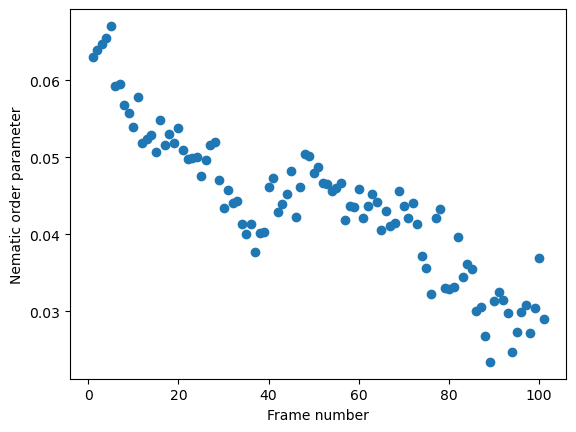

In [14]:
plt.scatter(frames, orders)
plt.xlabel("Frame number")
plt.ylabel("Nematic order parameter")

In [15]:
def nop(frame):
    positions = frame.particles.position
    molecule_ids = frame.bonds.group
    temp = positions[0]
    vectors = []
    for i, pos in enumerate(positions):
            if i < len(molecule_ids):
                vectors.append(np.stack(pos) - np.stack(temp))
                temp = pos
    vectors = np.array(vectors[1:])
    return vectors

In [17]:
nematic = freud.order.Nematic()
import time
start = time.process_time()
orders = []
frames = []
count = 0
for frame in traj:
    count += 1
    frames.append(count)
    nematic.compute(nop(frame))
    orders.append(nematic.order)
    print("Nematic Order Parameter:", nematic.order)
print("Time taken:", time.process_time() - start, "s")

Nematic Order Parameter: 0.062114790081977844
Nematic Order Parameter: 0.06347697228193283
Nematic Order Parameter: 0.06430051475763321
Nematic Order Parameter: 0.06559489667415619
Nematic Order Parameter: 0.06571010500192642
Nematic Order Parameter: 0.0592149943113327
Nematic Order Parameter: 0.059713974595069885
Nematic Order Parameter: 0.05790295451879501
Nematic Order Parameter: 0.05549399182200432
Nematic Order Parameter: 0.05345447361469269
Nematic Order Parameter: 0.05743136256933212
Nematic Order Parameter: 0.050887107849121094
Nematic Order Parameter: 0.0528646819293499
Nematic Order Parameter: 0.05359046161174774
Nematic Order Parameter: 0.05100230127573013
Nematic Order Parameter: 0.05550985410809517
Nematic Order Parameter: 0.05182778090238571
Nematic Order Parameter: 0.05161478370428085
Nematic Order Parameter: 0.05069185793399811
Nematic Order Parameter: 0.05300920084118843
Nematic Order Parameter: 0.050368525087833405
Nematic Order Parameter: 0.04851864278316498
Nematic 

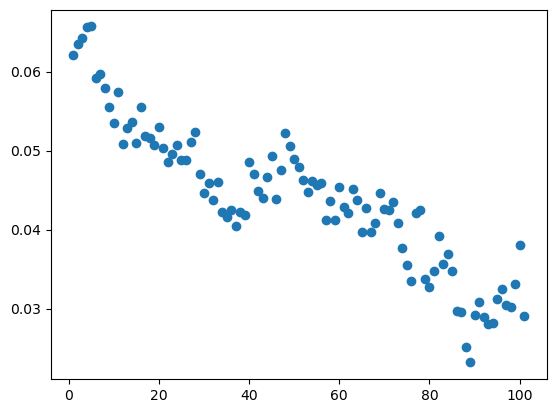

In [18]:
plt.scatter(frames, orders)